# Intercluster Evaluations with TComplexity Measures
This code loads content using a MYSQL Read operation, clusters it according to settings, then evaluates the clusters and computes a complexity measurement using FLOTT.

End result: A Histogram of Pairwise Distances for a particular similairity Threshold

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import external_utils as eu
import time
import flott
import sqlalchemy
import thresholdCluster
import json
import os

In [3]:
#//Data Load
searchName = 'Vancouver'
searchUUID = eu.getUUID(searchName)


#Read in the Data from MYSQL
t0=time.time()

#store passphrase in 
dbf = open('/code/masc-cluster/dbstring.txt','r') 
dbstring = dbf.read()
engine = sqlalchemy.create_engine(dbstring)

#sqlString = 'select * from searches;'
sqlString = "select meta_index.id as post_id, meta_index.created_at as capture_time, meta_index.publisher_id as publisher_id, content_cache.content_text as content_text from searches join search_meta on searches.id = search_meta.search_id join meta_index on search_meta.meta_id = meta_index.id join content_cache on meta_index.id = content_cache.meta_id where meta_index.service = 'twitter' and searches.uuid like '"+searchUUID+"';"

df = pd.read_sql(sqlString, engine)

#change columns and add information rows
df.columns=['PID', 'Date', 'UID', 'Content']
df['clusterID'] = 0
df['dLead'] = 0.0
df['isClustered'] = False
df['isEvaluated'] = 0

print('Data Loaded', time.time()-t0, 's')

#---------------->

Data Loaded 1.9508717060089111 s


In [3]:
#//Experiment Settings
#Create a save folder for data and results
experimentName = 'TInfoPairWiseHist_0924'
experimentPath = '/code/results/'+experimentName+'/'
if not os.path.exists(experimentPath):
    os.makedirs(experimentPath)

#sample = False
sample = True
n = 8500

#k iterations
k = 1

#output verbosity
verbose = False#True

#threshold for distance measure(?)
Thresholds = [0.5]#, 0.5, 0.8]

#minimum cluster size
minCluster = 10

clusterType = 'Naive'

#Similarity Measures
#Options: 'Jaccard' 'TInfo', 'LevToken' 

##DONT TOUCH IN THIS VERSION
Measures = ['TInfo']#, 'LevToken']

print('Settings Saved')

Settings Saved


In [4]:
#Cluster and Evalutate, k times
if(verbose):
    print('Starting:', end='')

    
resultsFrameRows = len(Measures)*len(Thresholds)*k
index = range(0,resultsFrameRows)
columns = ['measure', 'threshold', 'sample',
           'time', 'calculations', 'avgRMSD',
           'nclusters','unclustered', 'reduction',
           'cSizes']
rf = pd.DataFrame(index=index,columns=columns, dtype='object')

#k samples
count = 0
print('Starting: '+DataTitle)
for j in range(0,k):
    print('Sample: ',j)
    dfn0 = df.sample(n) 
    for measure in Measures:   
        
        #get original sample
        dfn1 = dfn0.copy()
        cMs = {}
        cDs = {}
        clusterDists = {}
        print('Starting Measure', measure)
        
        for threshold in Thresholds:
            dfn1, tElapsed, calc = thresholdCluster.runNaive(dfn1, threshold, minCluster, measure, verbose)
            # dfn, threshold, minCluster, measure, clustertype, verbose, elapsed, calcs
            dfn1, r, cMs[threshold], cDs[threshold] = thresholdCluster.evaluateClusterMetrics(dfn1, threshold, minCluster, measure, 
                                                  clusterType, verbose, tElapsed, calc)
            
            rf.loc[count] = [measure, threshold, j,
                                      r['timeElapsed'],r['calculations'],r['avgRMSD'],
                                      r['nClusters'],r['unClustered'],r['reduction'],
                                      'blank']
            rf.at[count, 'cSizes'] = r['clusterSizes']
             
            count+=1
print('-------------------> Done <----------------------')

Starting: London
Sample:  0
Starting Measure TInfo
Threshold:  0.5  Completed in: 2701.3     Evaluation Done: 6.5
-------------------> Done <----------------------


In [6]:
#Save Content Block - If you want to save it for later. Helps deal with Memory issues as a result of FLOTT
#Save Results Dataframe
thresh = Thresholds[0]
saveResultsFrame = experimentPath+DataTitle+clusterType+str(thresh)+'ResultsDataframe5000.csv'
rf.to_csv(saveResultsFrame)

#Convert cMs to DataFrames and Save
for key in cMs:
    cM = pd.DataFrame.from_dict(cMs[key], orient='index')
    cM.columns= ['Size','Max','Min','STD','Mean','Median', 'Complexity']
    saveClusterFile = experimentPath+DataTitle+clusterType+str(key)+'ClusterMetricsDataframe.csv'
    cM.to_csv(saveClusterFile)    


#Convert cDs keys to strings and Save 
tempDict = {}
for th in cDs:
    tempDict[str(th)]={}
    for key in cDs[th]:
        tempDict[str(th)][str(key)] = cDs[th][key]
    
    clusterDataFilename = DataTitle+clusterType+str(th)+'CDS.csv'
    saveCDS = experimentPath+clusterDataFilename

    with open(saveCDS, 'w') as file:
        json.dump(tempDict, file)


In [20]:
#Load Data Block - inverse of Save Block.
'''saveResultsFrame = experimentPath+DataTitle+clusterType+'ResultsDataframe.csv'
clusterDataFilename = DataTitle+clusterType+str(0.6)+'CDS.csv'
saveCDS = experimentPath+clusterDataFilename

#load Results Frame
rf1 = pd.read_csv(saveResultsFrame, index_col=0)

cm4 = pd.read_csv(saveClusterFile, index_col=0)
load Cluster Data
with open(saveCDS, 'r') as file:
    cDsStringKeyed = json.load(file)'''

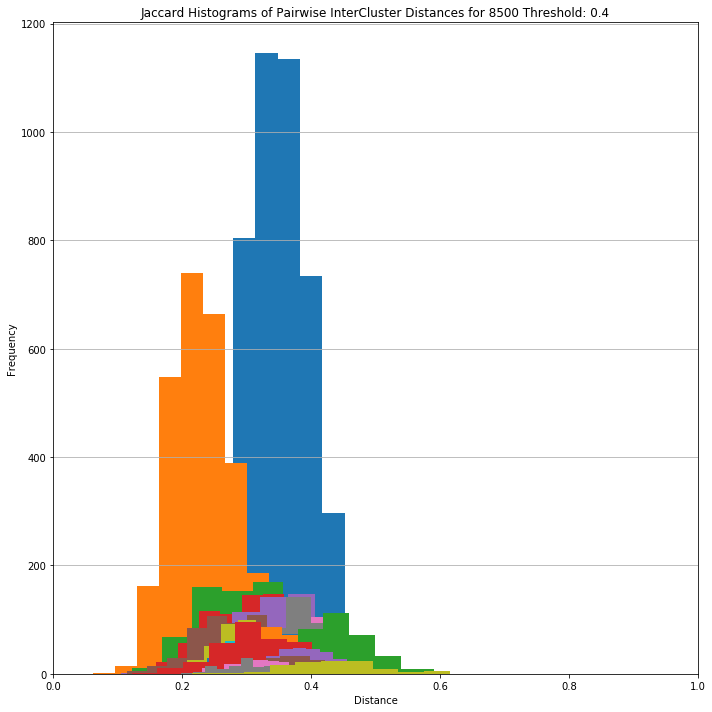

In [54]:
#Plot Histograms of Pairwise Intercluster Distances
#Parameters must be changed subject to the settings.

fig = plt.figure(1, figsize=(10,10))
th = 0.4
measure='Jaccard'
#plt.subplot(3,2,5)
for key in cDs[th]:
    plt.hist(cDs[th][key])
    
plt.title(measure+' Histograms of Pairwise InterCluster Distances for '+ str(n) +' Threshold: '+str(th))
plt.grid(axis='y')
#plt.legend(cM.Size)
plt.xlim(0,1)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(experimentPath+DataTitle+'Hist'+measure+str(th)+'.png')

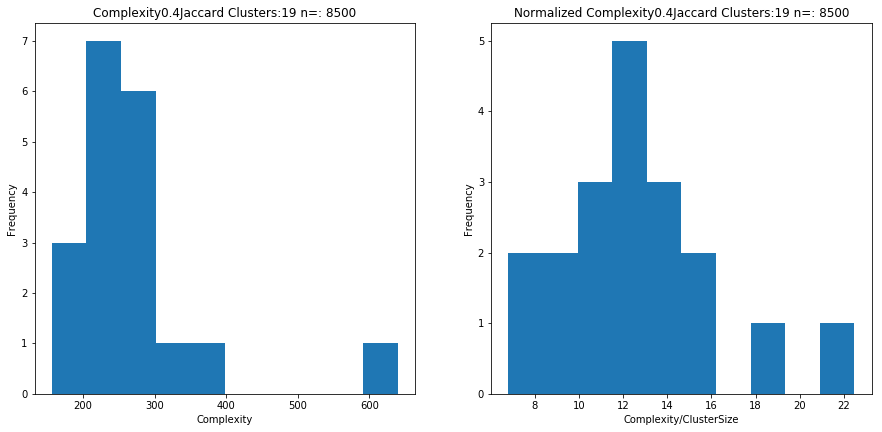

In [55]:
#Plot Cluster Complexity Histograms
fig = plt.figure(1, figsize=(15,15))
i=1
measure='TInfo'
nplots = len(Thresholds)
for th in Thresholds:
     
    cplx = []
    sizes = []
    for key in cMs[th]:
        cplx.append(cMs[th][key][6])
        sizes.append(cMs[th][key][0])
    plt.subplot(nplots*2,2,i)
    plt.hist(cplx)
    plt.title('Complexity' + str(th) + 'Jaccard Clusters:' + str(len(cplx)) +' n=: '+str(n))
    plt.xlabel('Complexity')
    plt.ylabel('Frequency')
    
    plt.subplot(nplots*2,2,i+1)
    plt.hist(np.divide(cplx,sizes))
    plt.xlabel('Complexity/ClusterSize')
    plt.ylabel('Frequency')
    plt.title('Normalized Complexity' + str(th) + 'Jaccard Clusters:' + str(len(cplx))+' n=: '+str(n))
    i+=2
plt.savefig(experimentPath+DataTitle+'ComplexityHists'+measure+str(th)+'.png')

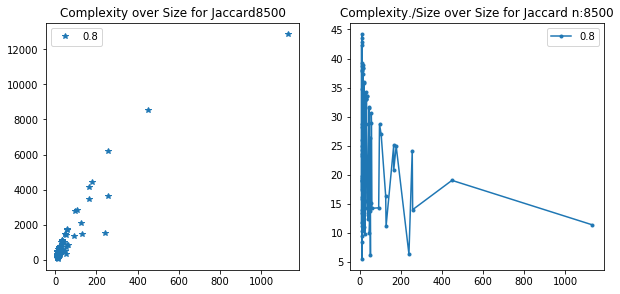

In [11]:
fig = plt.figure(1, figsize=(10,10))
for th in Thresholds:
    cplx = []
    sizes = []
    for key in cMs[th]:
        cplx.append(cMs[th][key][6])
        sizes.append(cMs[th][key][0]) 
        
    plt.subplot(2,2,1)
    plt.plot(sizes, cplx, '*')
    plt.legend(Thresholds)
    plt.title('Complexity over Size for Jaccard'+str(n))
    
    plt.subplot(2,2,2)
    plt.plot(sizes, np.divide(cplx, sizes), '.-')
    plt.legend(Thresholds)
    plt.title('Complexity./Size over Size for Jaccard n:' +str(n))
    
plt.savefig(experimentPath+DataTitle+'ComplexitySizeLines'+measure+str(th)+'.png')